# 4c. Evaluate predictions of emergency demand

The previous notebook demonstrated the full implementation in code of training models for use at UCLH using the functions provided in `patientflow`. I demonstrated how we create predictions for a single snapshot. 

This notebooks show evaluate the predicted distributions against observed numbers, for the whole test set. I will evaluate the predictions by specialty using the approaches covered in a [previous notebook](3b_Evaluate_group_snapshots.ipynb).

* Histograms of observed versus expected values
* Adjusted QQ plots

As the predictions for yet-to-arrive patients are aspirational, these cannot be directed evaluated against observed numbers of admissions in the prediction window. In reality, due to poor ED performance, few may have been admitted within the window. Similarly for the group of patients in the ED, we calculate the predicted number of beds needed within the prediction window, but the observed numbers will not reflect the targets.

We can, however, evaluate the predictions in a slightly different way. 

* For the patients in ED, we can compare the predicted bed counts needed for each specialty against observed numbers admitted to each specialty from among patients comprising each group snapshot in the test set period, without taking into account how long it takes each patient to be admitted.
* For the yet-to-arrive patients, we can compare the predicted with the observed arrival rates within the prediction window.

## Loading data and parameters
### Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


### Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

As noted previously, you can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)

In [4]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


### Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [5]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


### Apply temporal splits

In [6]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]


## Evaluating models that predict demand for patients current in the ED

The demand predictions for patients current in the ED bring together the admissions and specialty models. First we train each model, with a separate admissions model for each prediction time, and a single model to predict specialty of admission, if admitted. 

### Train admissions models 

This process has already been shown in previous notebooks. This time I'll use a larger parameter grid, while still limiting the search space to a few hyperparameters for expediency.

In [7]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = { # Current parameters
    'n_estimators': [30, 40, 50],  # Number of trees
    'subsample': [0.7, 0.8, 0.9],  # Sample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Sample ratio of columns for each tree
   } 

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Train specialty model

In [8]:
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor
from patientflow.predictors.subgroup_predictor import MultiSubgroupPredictor

def create_subgroup_functions_from_age_group():
    """Create subgroup functions that work with age_group categorical variable."""
    
    def is_paediatric(row):
        return row.get("age_group") == "0-17"
    
    def is_adult(row):
        # All non-paediatric patients are adults
        return row.get("age_group") != "0-17"
    
    return {
        "paediatric": is_paediatric,
        "adult": is_adult,
    }

subgroup_functions = create_subgroup_functions_from_age_group()

spec_model = MultiSubgroupPredictor(
    subgroup_functions=subgroup_functions,
    base_predictor_class=SequenceToOutcomePredictor,
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    min_samples=50,  # Minimum samples required per subgroup
)
spec_model = spec_model.fit(train_visits_df)

### Generate predicted distributions for each specialty and prediction time for patients in ED

As we are treating paediatric patients differently from adults, the function below includes logic to identify eligible snapshots when caclculating for paediatric versus adult subgroups. When evaluating the predictions for adult destinations (medical, surgical and haem/onc), patients under 18 will be excluded. When evaluating the predictions for paediatric patients, adults will be excluded.

The code has been shown here to demonstrate how in the UCLH implementation, we combine the admissions and specialty models to create predictions using the compound probability of admission after the ED visit, and admission to a given specialty. There is optional parameter to use a baseline probability for admission to specialty, which will be discussed later. 

In [9]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.load import get_model_key


def get_specialty_probability_distributions(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name,
    exclude_from_training_data,
    specialties=['medical', 'surgical', 'haem/onc', 'paediatric'],
    baseline_prob_dict=None,
):
    """
    Calculate probability distributions for emergency department patients by specialty and prediction time.
    
    Args:
        test_visits_df: DataFrame containing test visit data
        spec_model: Model for specialty predictions (SequencePredictor)
        admissions_models: Dictionary of admission prediction models
        model_name: Name of the model to use
        specialties: List of specialties to consider
        exclude_from_training_data: List of columns to exclude from training data
        baseline_prob_dict: Optional dict of baseline probabilities to use instead of spec_model predictions
        
    Returns:
        Dictionary containing probability distributions for each specialty and prediction time
    """

    # Get predictions of admission to specialty
    if baseline_prob_dict is not None:
        # Use baseline probabilities instead of model predictions
        test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(
            lambda row: baseline_prob_dict,
            axis=1
        )
    else:

        if hasattr(spec_model, "predict_dataframe"):
            # Get specialty probabilities for all patients using predict_dataframe
            test_visits_df.loc[:, "specialty_prob"] = spec_model.predict_dataframe(test_visits_df)
        else:
            # Fallback for SequenceToOutcomePredictor (original behavior)
            def determine_specialty(row):
                return spec_model.predict(row["consultation_sequence"])
            
            test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(determine_specialty, axis=1)
            # Initialize dictionary to store probability distributions
    prob_dist_dict_all = {}

    # Process each time of day
    for _prediction_time in test_visits_df.prediction_time.unique():
        prob_dist_dict_for_pats_in_ED = {}
        print("\nProcessing :" + str(_prediction_time))
        model_key = get_model_key(model_name, _prediction_time)
        
        for specialty in specialties:
            print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
        

            # Get probability of admission to specialty for eligible patients
            prob_admission_to_specialty = test_visits_df["specialty_prob"].apply(
                lambda x: x.get(specialty, 0.0) if isinstance(x, dict) else 0.0
            )
            
            # Prepare patient snapshots
            X_test, y_test = prepare_patient_snapshots(
                df=test_visits_df, 
                prediction_time=_prediction_time, 
                single_snapshot_per_visit=False,
                exclude_columns=exclude_from_training_data, 
                visit_col='visit_number'
            )

            # Prepare group snapshots
            group_snapshots_dict = prepare_group_snapshot_dict(
                test_visits_df[test_visits_df.prediction_time == _prediction_time]
            )

            admitted_to_specialty = test_visits_df['specialty'] == specialty

            # Get probability distribution for this time and specialty
            prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
                group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
                weights=prob_admission_to_specialty,
                category_filter=admitted_to_specialty, 
                normal_approx_threshold=30
            )

        prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED

    return prob_dist_dict_all

In [10]:
prob_dist_dict_all = get_specialty_probability_distributions(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name,
    exclude_from_training_data
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

### Visualise the performance of emergency demand prediction models for patients in the ED

Below I use two approaches to evaluate the predicted distributions. 
* Histograms of observed versus expected values
* Adjusted QQ plots

See [a previous notebook](3b_Evaluate_group_snapshots.ipynb) for more on these approaches.


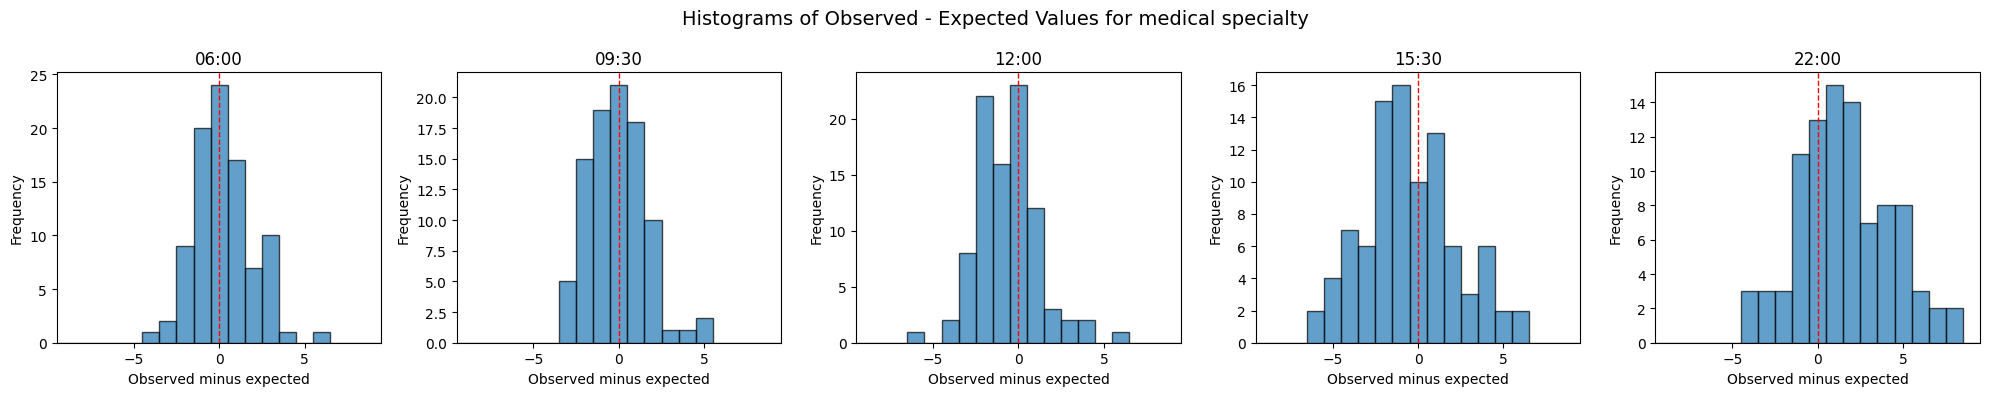

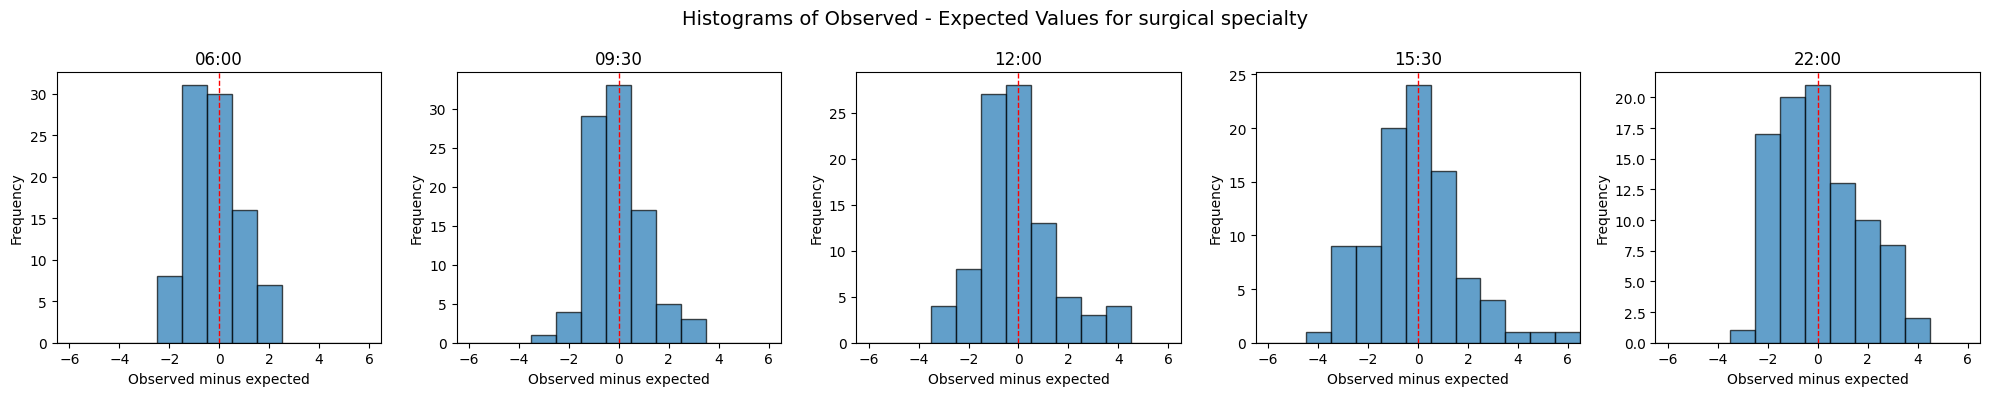

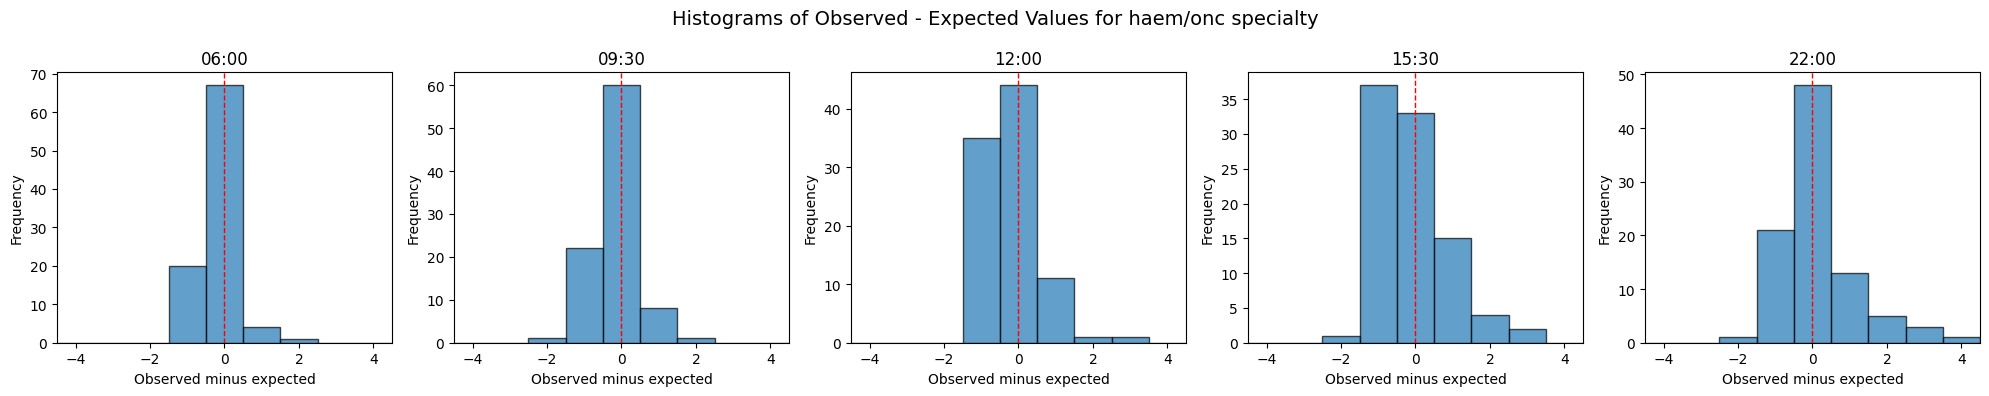

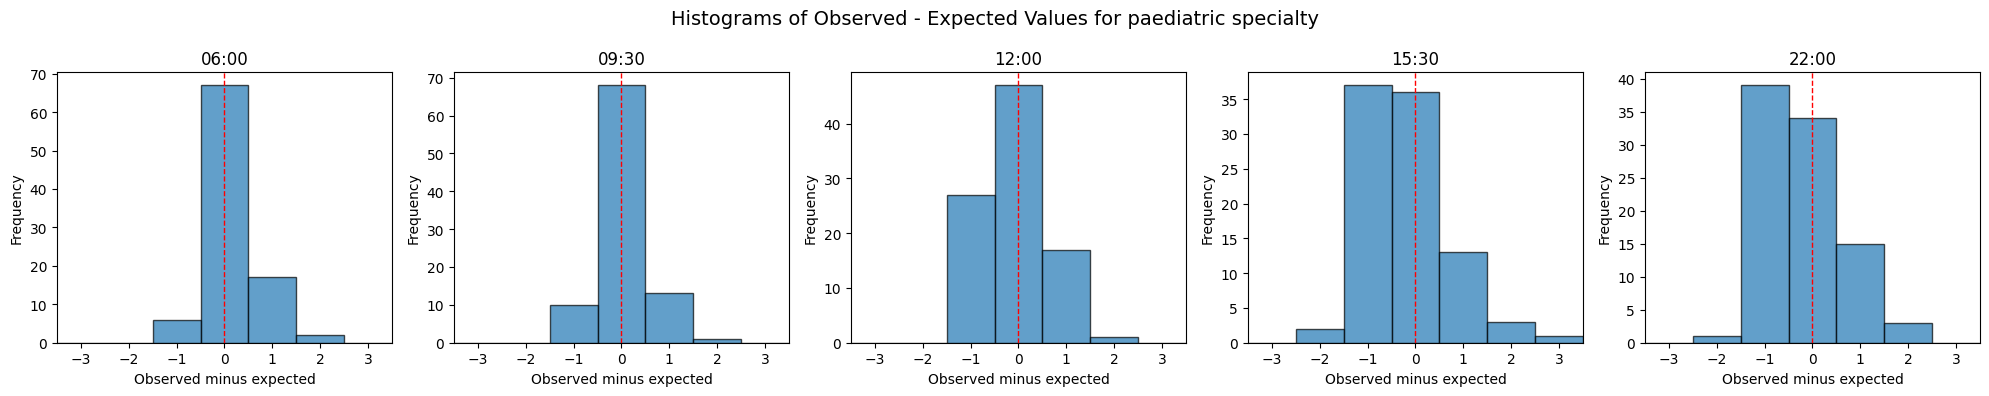

In [11]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.observed_against_expected import plot_deltas
specialties=['medical', 'surgical', 'haem/onc', 'paediatric']

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_deltas(results, suptitle=f"Histograms of Observed - Expected Values for {specialty} specialty",)


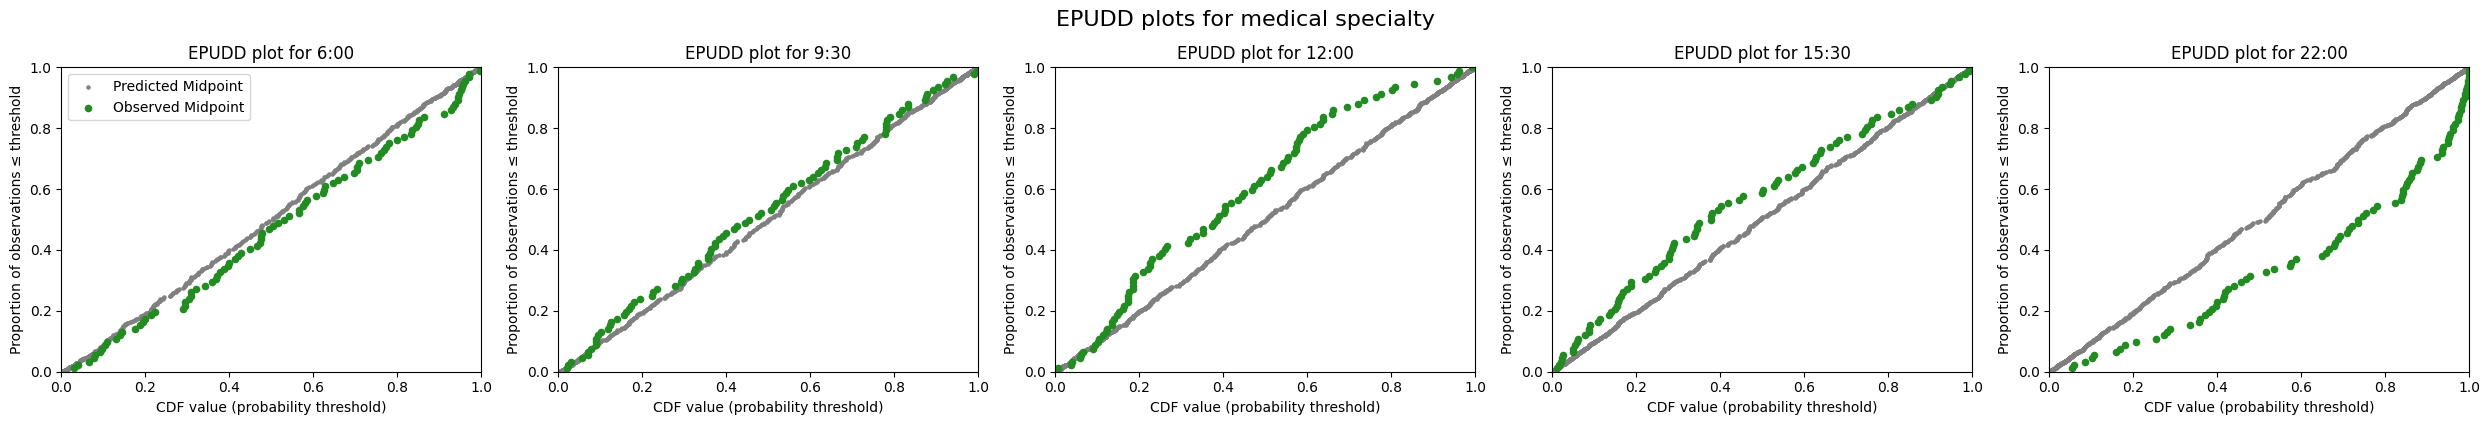

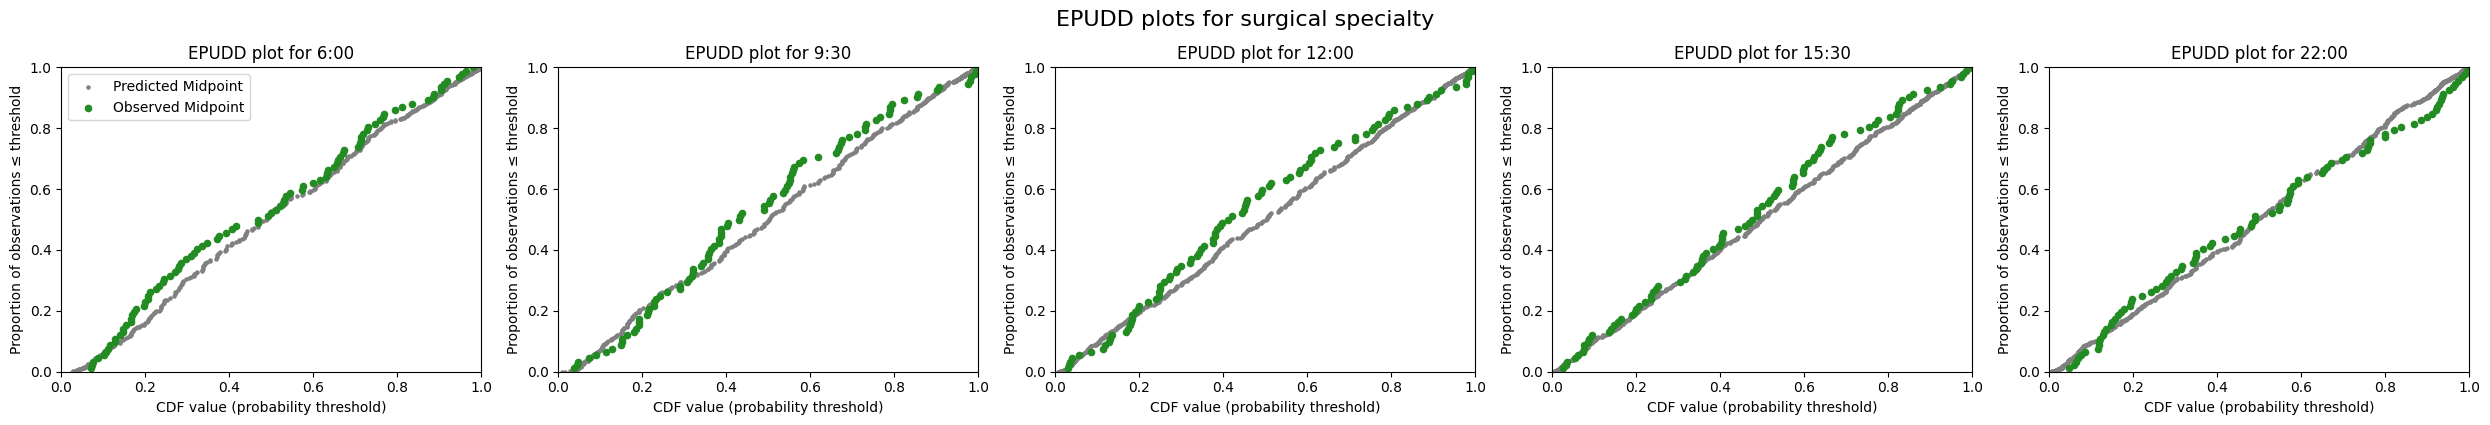

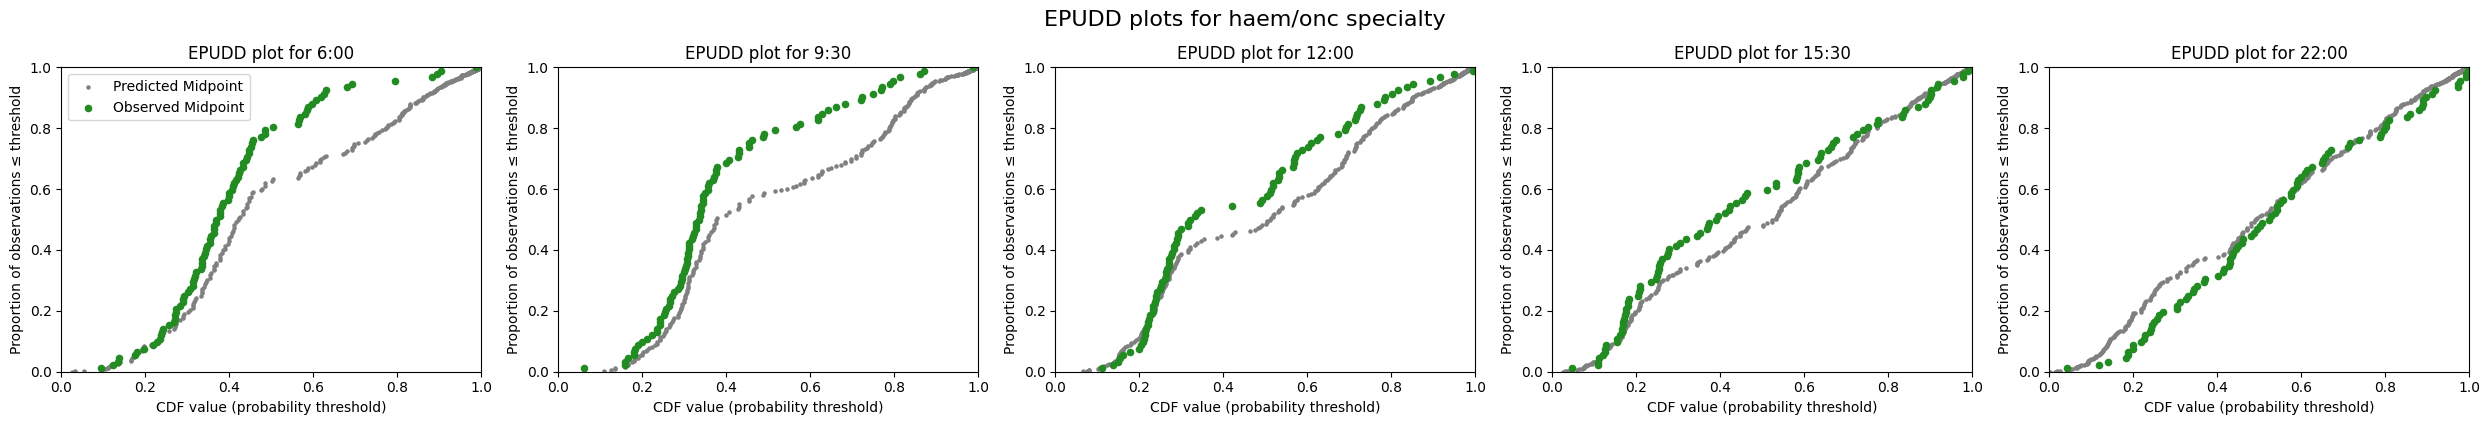

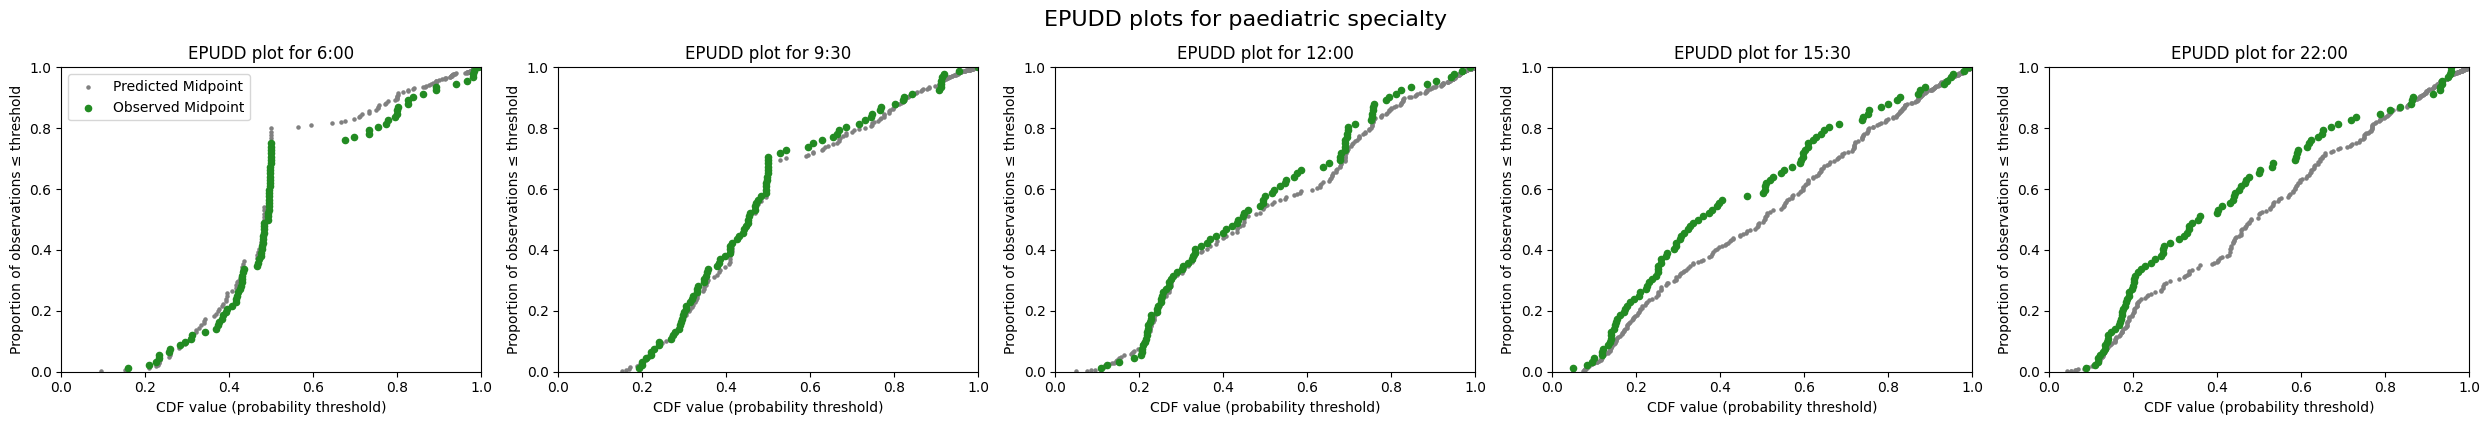

In [12]:
from patientflow.viz.epudd import plot_epudd
specialties=['medical', 'surgical', 'haem/onc', 'paediatric']

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    plot_epudd(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"EPUDD plots for {specialty} specialty")

In medical specialties (which have the highest numbers of admissions, accounting for significant majority) the model performance is similar to that seen when not sub-divided by specialty. (See [a previous notebook](3b_Evaluate_group_snapshots.ipynb) for more on this.) The model underestimates beds needed for patients in the ED at 22:00 and overestimates at 12:00 and 15:30. 

The model is well calibrated for surgical specialties. 

For haematology/oncology the model under-predicts at most times of day. For paediatrics, the observed values track the model predictions very well at 06:00 and 09:30. The model is less well calibrated later in the day.  

### Comparing with a baseline prediction by specialty

The model predicting specialty of admission was trained on sequences of consults. A baseline would be to give each adult patient the same probability of admission to medical, surgical or haem/onc, based on past averages. To calculate past averages, I'll use the `inpatient_arrivals` since this includes all arrivals, with one row for each visits. (Note - the `ed_visits` dataset has multiple rows per visit; I could use this by creating a subset that included only admitted patients with their specialty, and dropping duplicate rows. )

In [13]:
baseline_probs = train_inpatient_arrivals_df['specialty'].value_counts(normalize=True).to_dict()

prob_dist_dict_all_baseline = get_specialty_probability_distributions(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    exclude_from_training_data=exclude_from_training_data,
    baseline_prob_dict=baseline_probs
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

The output below shows two plots per specialty -  the baseline model using average proportions admitted to each specialty (upper), and a model where specialty of admission is predicted using consult sequences (below). Particularly for specialties with small admission numbers (haem/onc and paediatric) there is an improvement; the extent of over-prediction is reduced. 


EPUDD plots for medical specialty: baseline vs sequence predictor


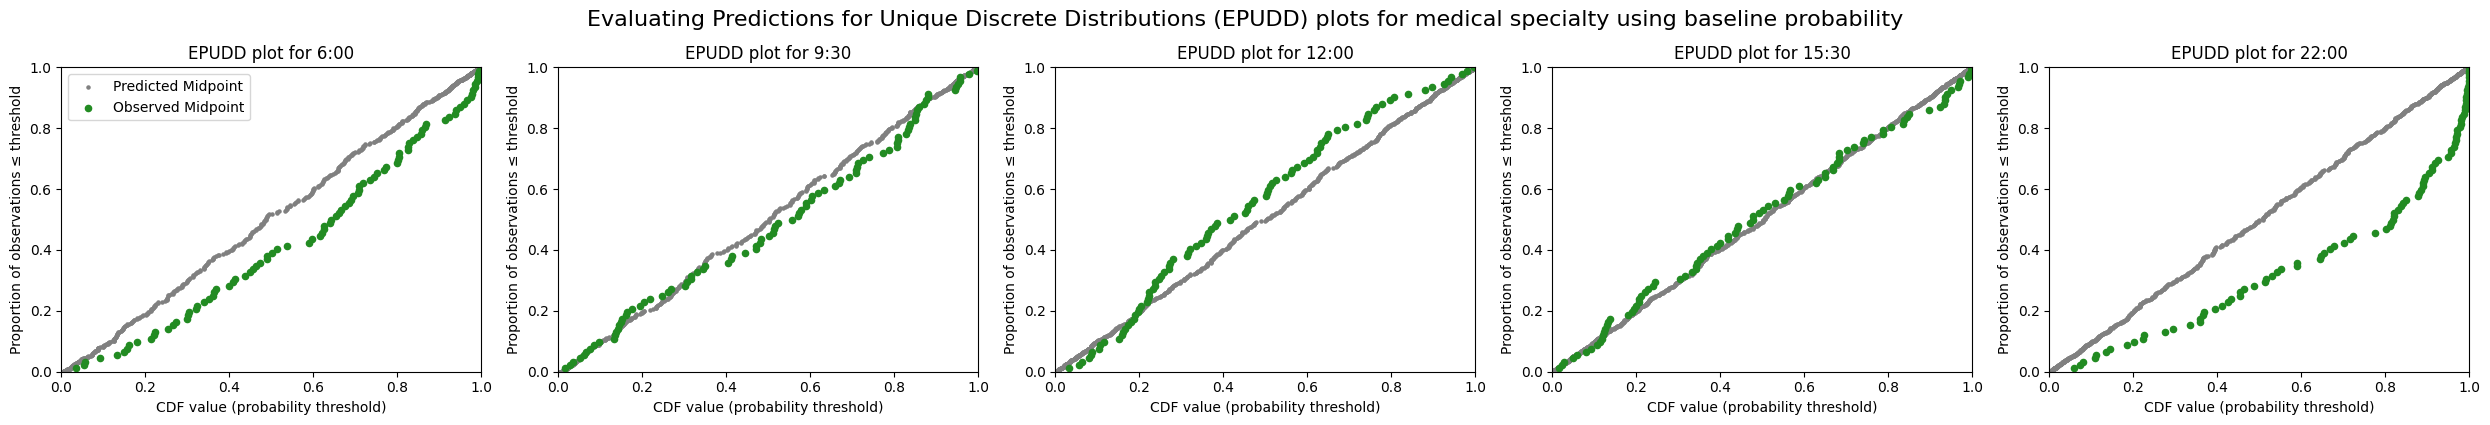

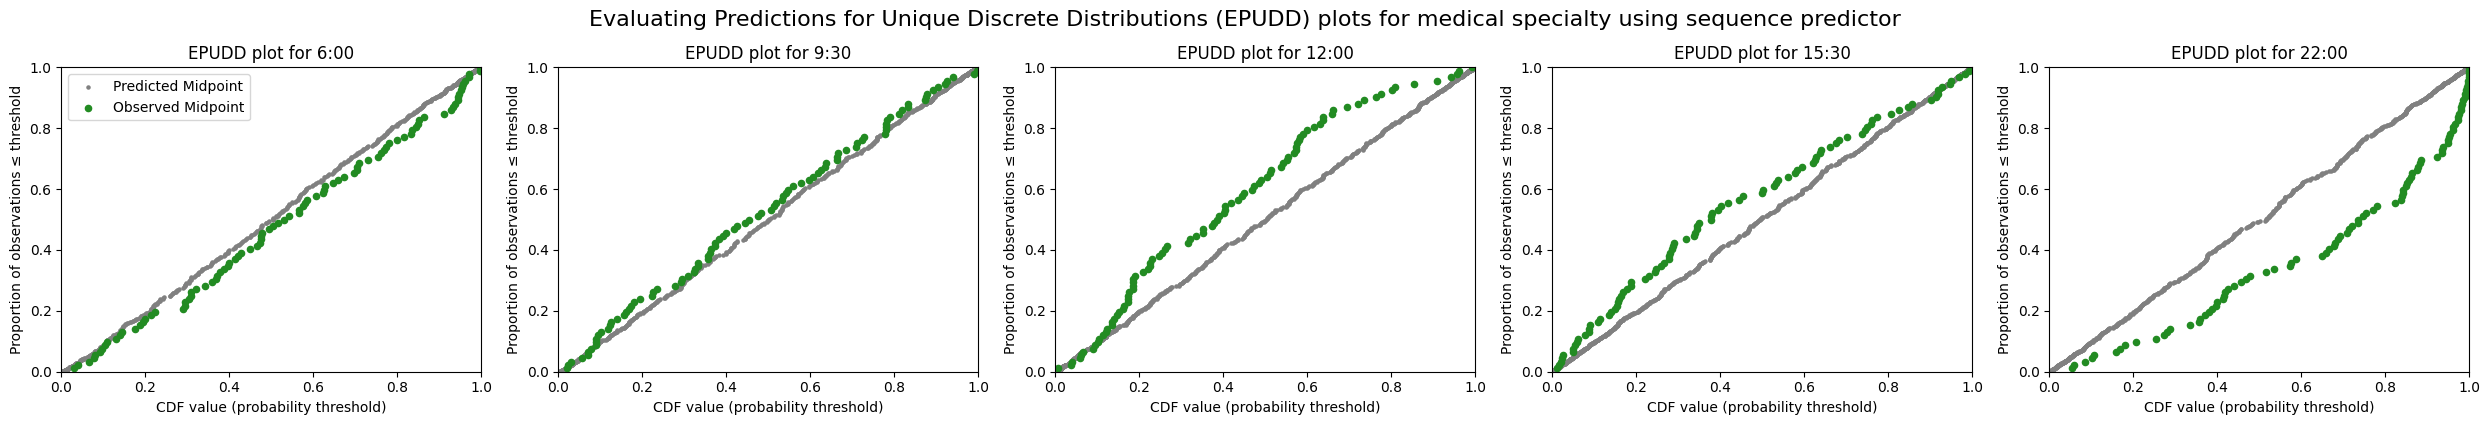


EPUDD plots for surgical specialty: baseline vs sequence predictor


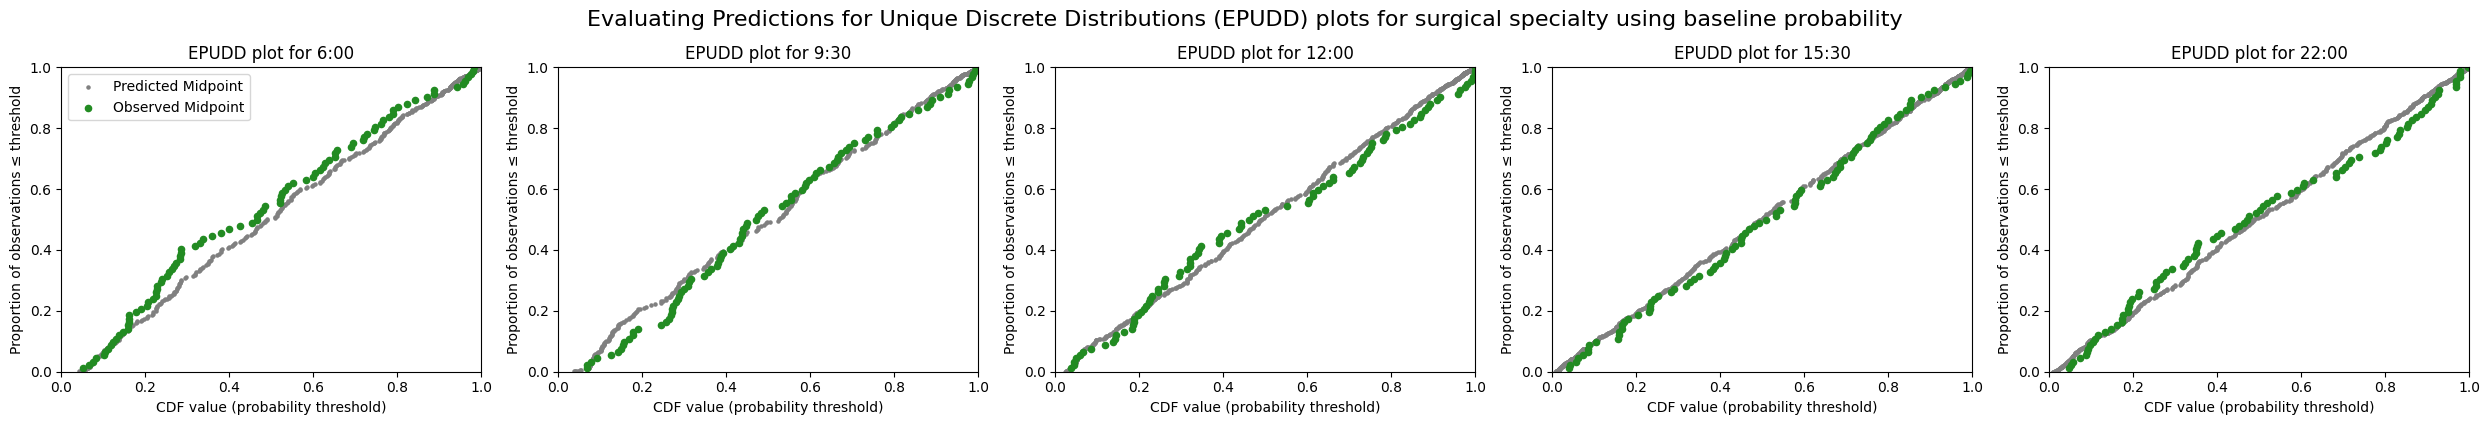

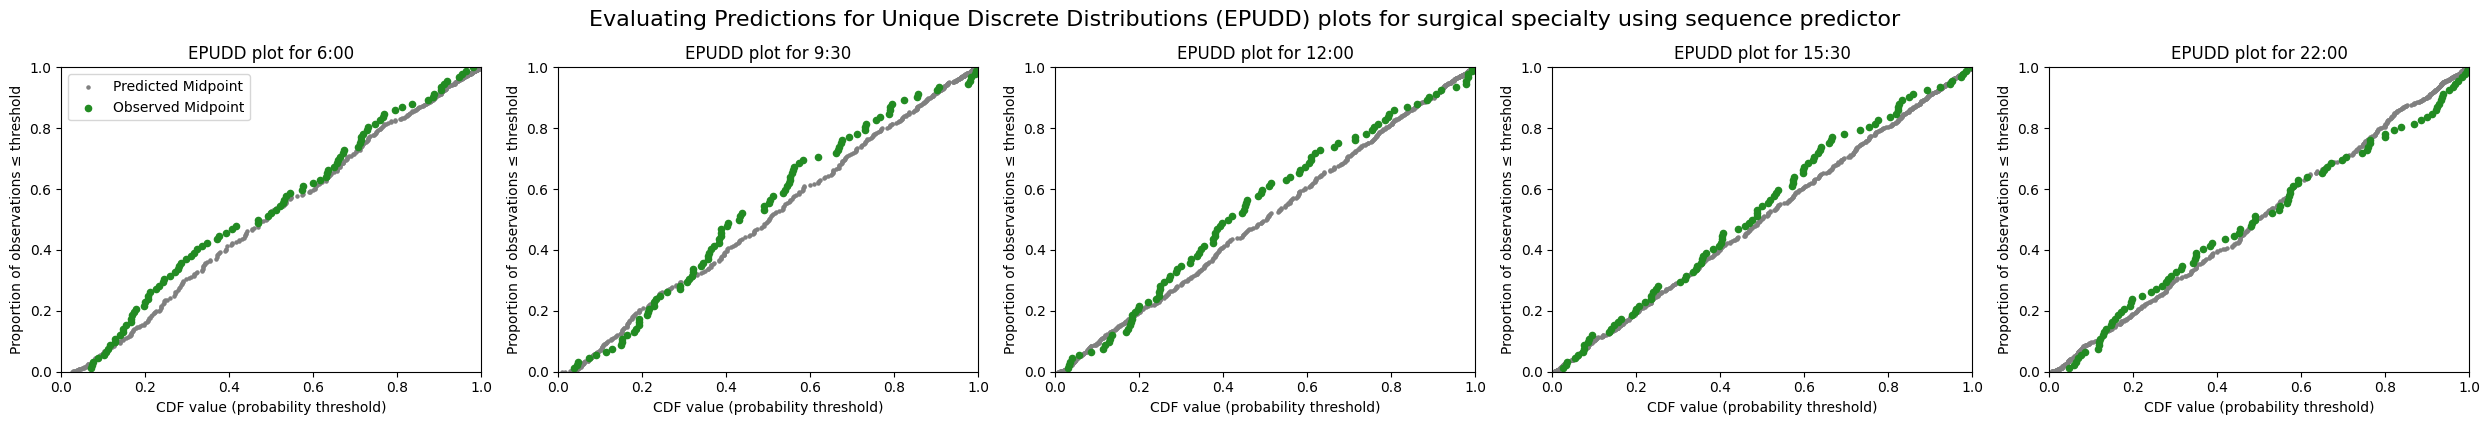


EPUDD plots for haem/onc specialty: baseline vs sequence predictor


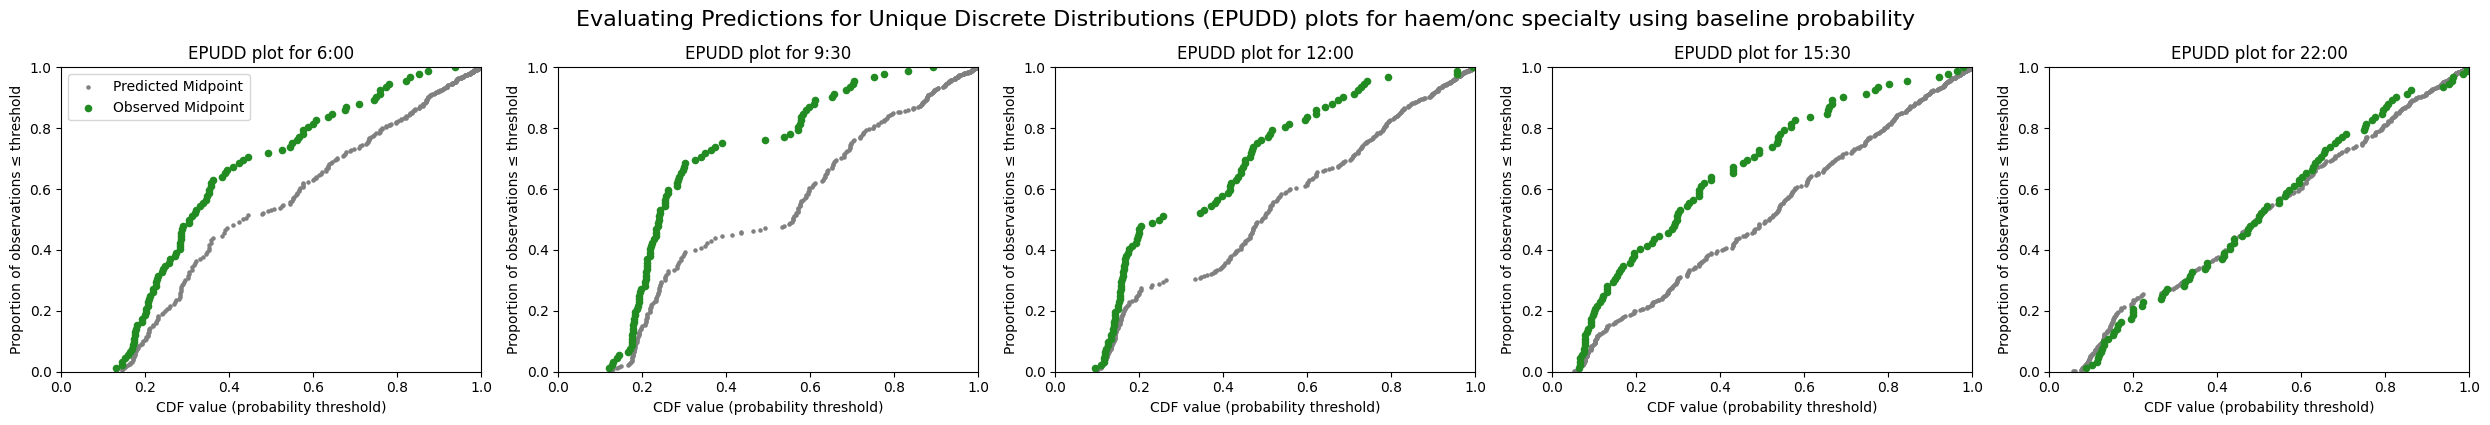

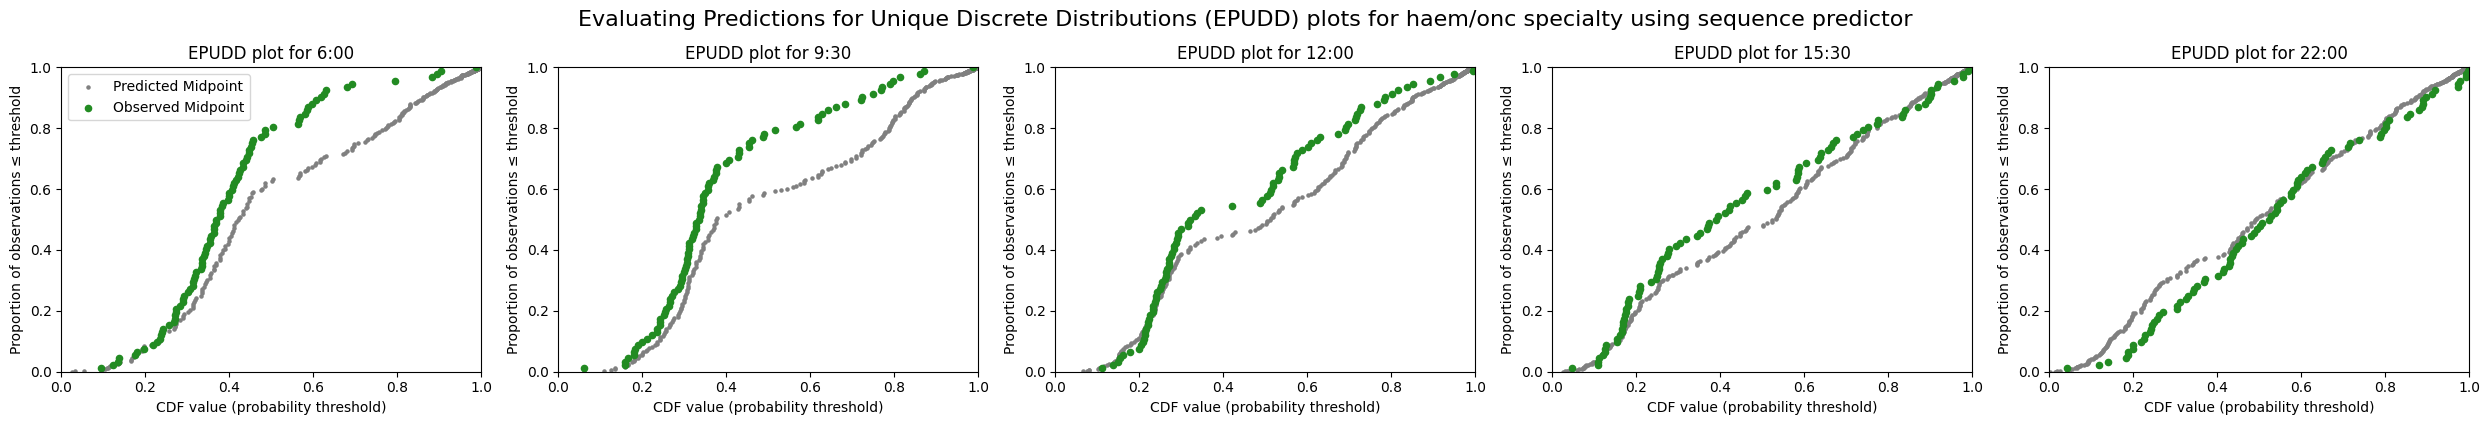


EPUDD plots for paediatric specialty: baseline vs sequence predictor


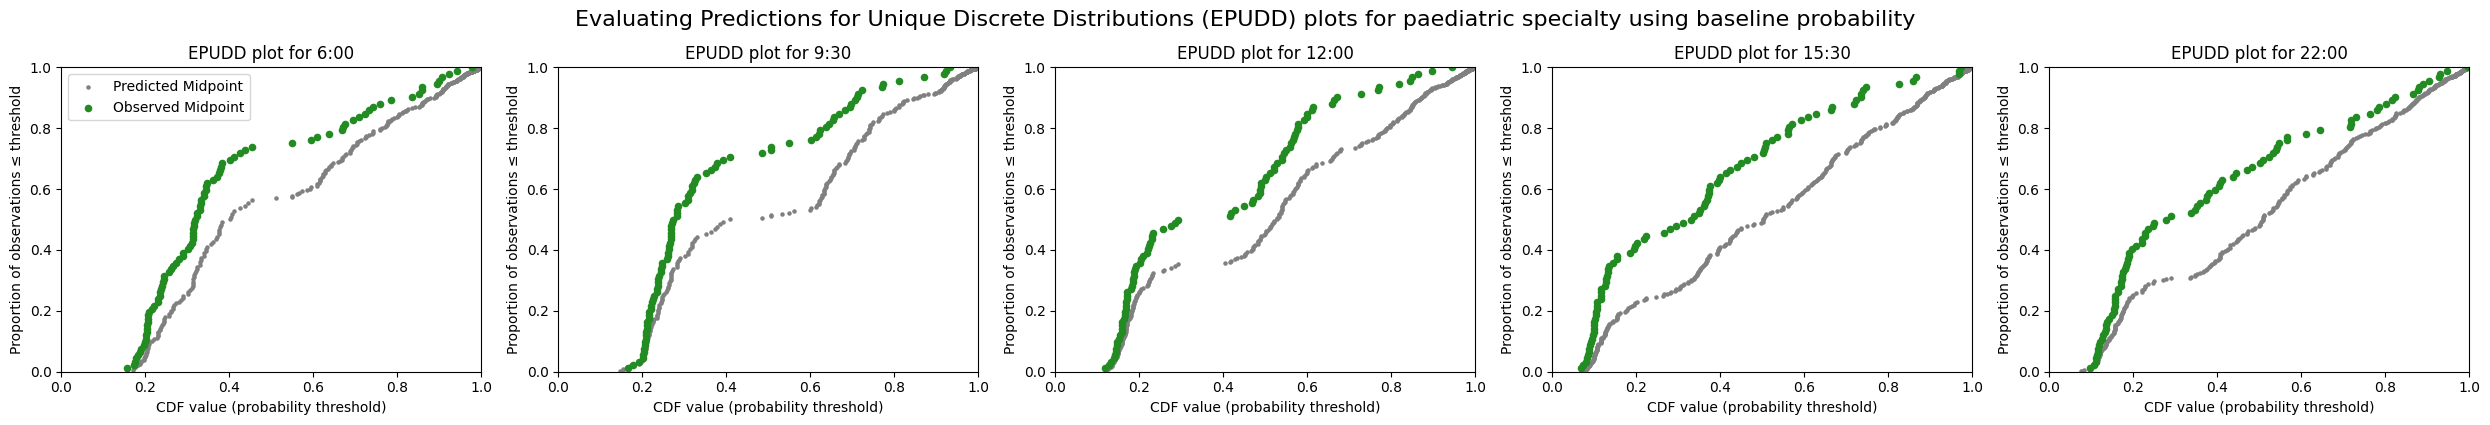

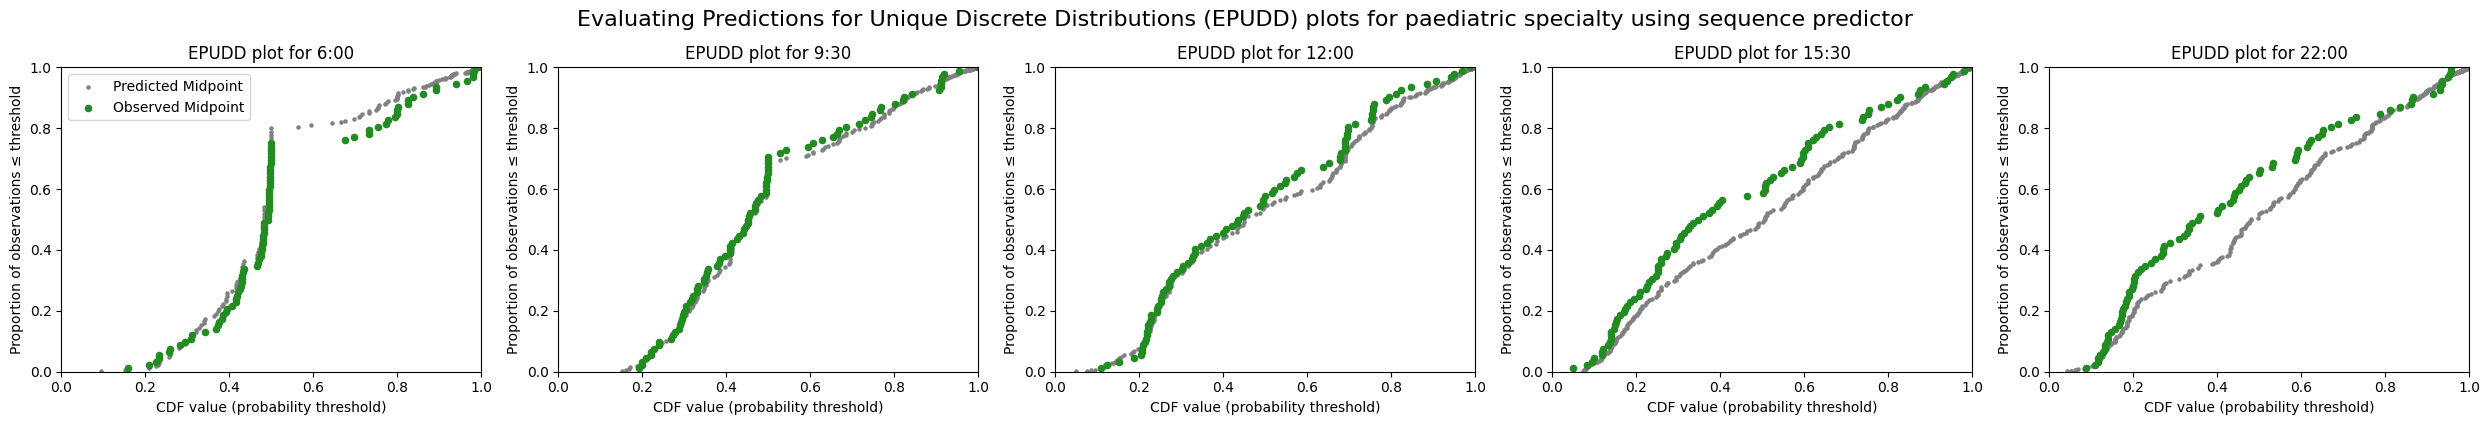

In [14]:
from patientflow.viz.epudd import plot_epudd

for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    specialty_prob_dist_baseline = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all_baseline.items()}
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    print(f'\nEPUDD plots for {specialty} specialty: baseline vs sequence predictor')

    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist_baseline,
        model_name="admissions",
        suptitle=f"Evaluating Predictions for Unique Discrete Distributions (EPUDD) plots for {specialty} specialty using baseline probability")
    
    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist,
        model_name="admissions",
        suptitle=f"Evaluating Predictions for Unique Discrete Distributions (EPUDD) plots for {specialty} specialty using sequence predictor")

## Evaluate predictions for patients yet-to-arrive to the ED

Predictions for patients yet-to-arrive are made up of two components:

* Arrival rates calculated from past data, prepared for a series of time intervals within a prediction window after the moment of prediction
* A probability of admission for any patient arriving within one of these time intervals being admitted within the prediction window. The probability of admission is generated using either an empirical survival curve, or an aspirational approach. 

We can evaluate these two components separately. 

## Evaluating arrival rates 

We can, however, compare the predictions based on arrival rates at the front door of ED, that were learned from the training set, against observed arrival rates at the front door during the test set. 

To illustrate, I start by plotting the cumulative arrivals of patients later admitted within a prediction window on one date. In the upper chart, the blue line shows the cumulative number of arrivals. The orange lines shows the cumulative mean arrival rate.

The lower chart shows the delta between the two lines


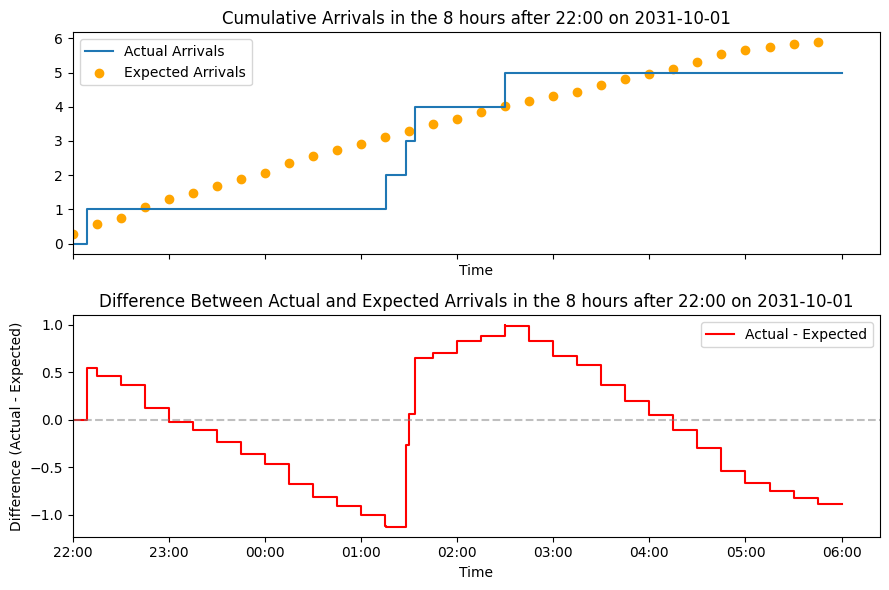

In [15]:
from patientflow.viz.observed_against_expected import plot_arrival_delta_single_instance
from datetime import timedelta

plot_arrival_delta_single_instance(test_inpatient_arrivals_df, 
                        prediction_time=(22,0), 
                        snapshot_date=start_test_set, 
                        show_delta=True, 
                        prediction_window=timedelta(minutes=params["prediction_window"]), 
                        yta_time_interval = timedelta(minutes=params["yta_time_interval"]),
                        fig_size=(9, 3)
                        )


# plt.show()

The chart below shows multiple version of the delta for each date in the test set, for each prediction time, with the average delta shown in red. 

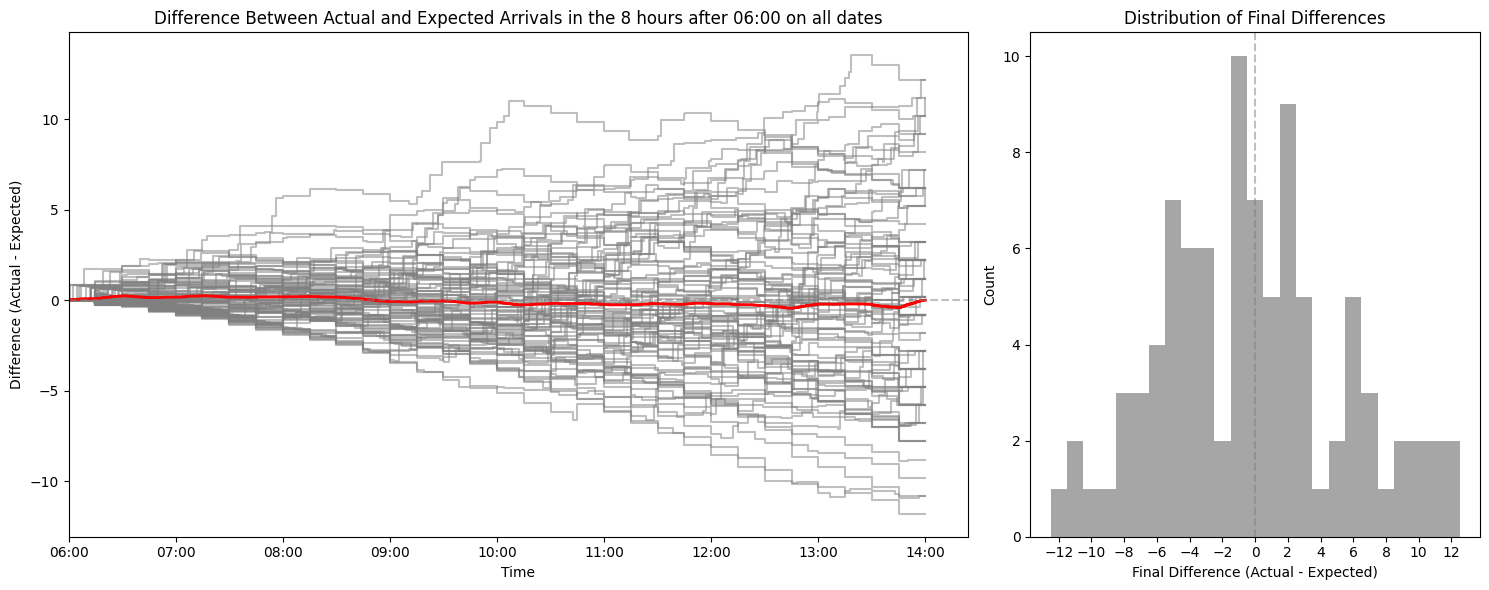

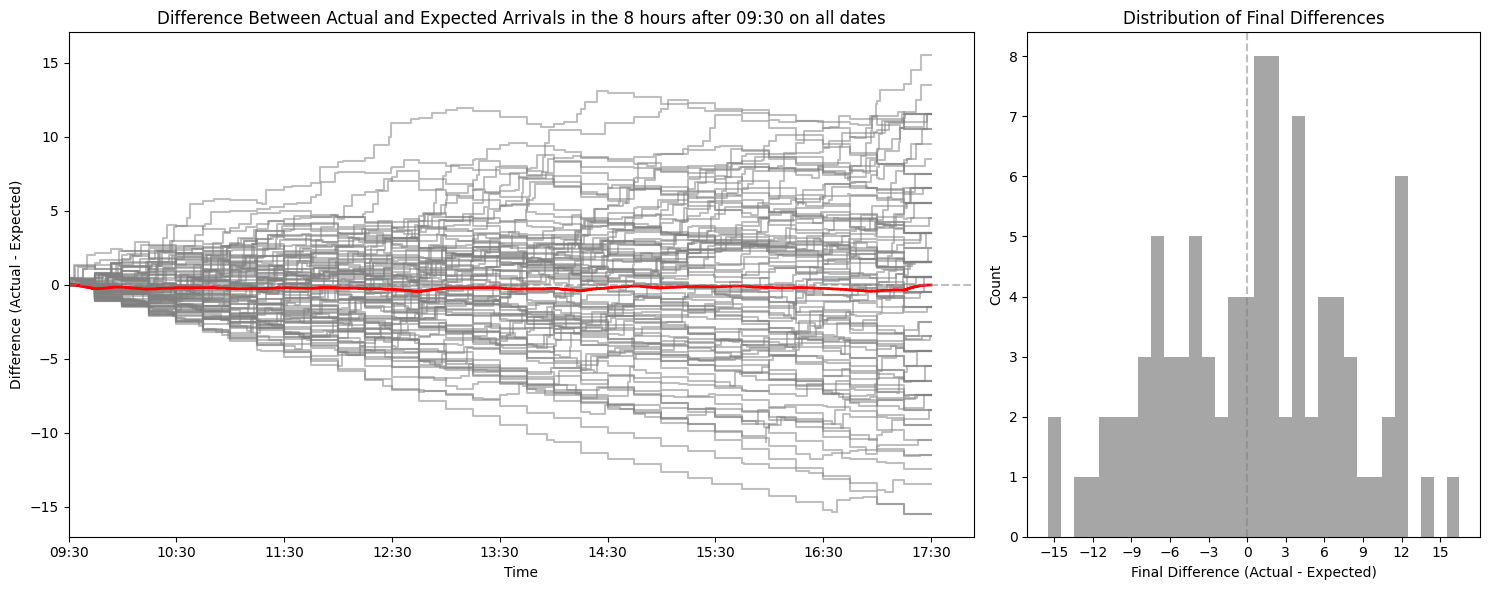

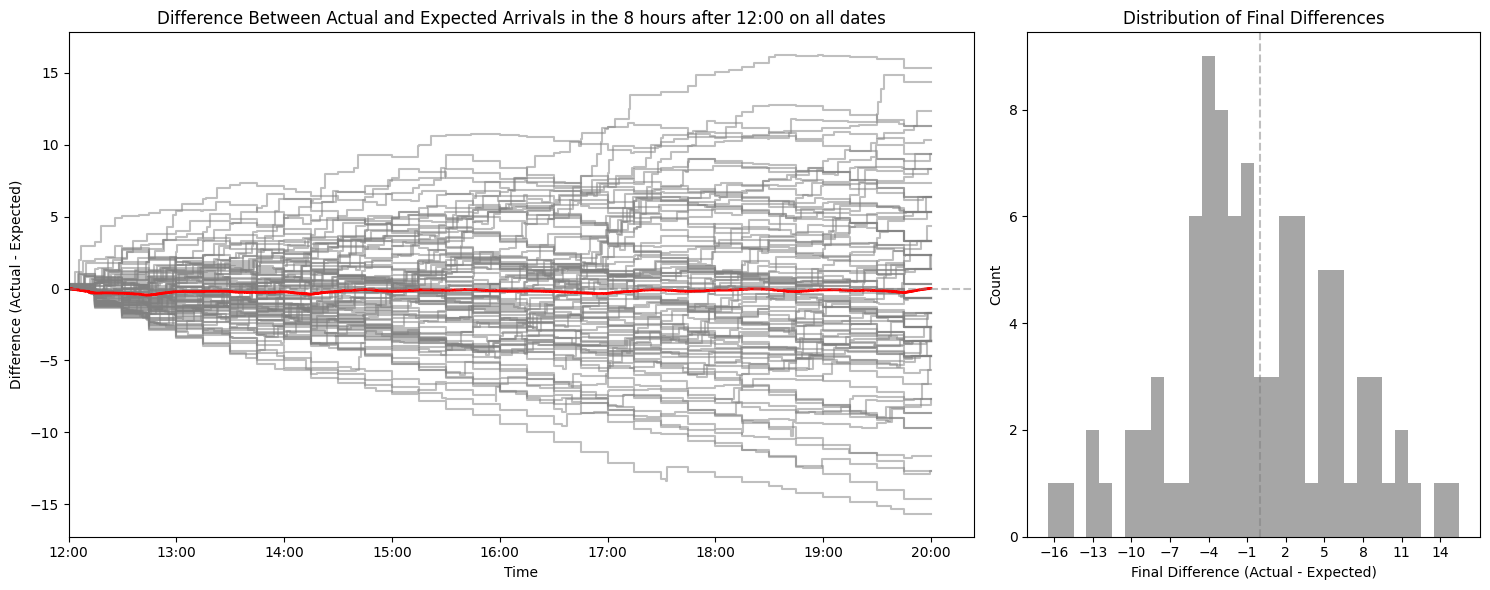

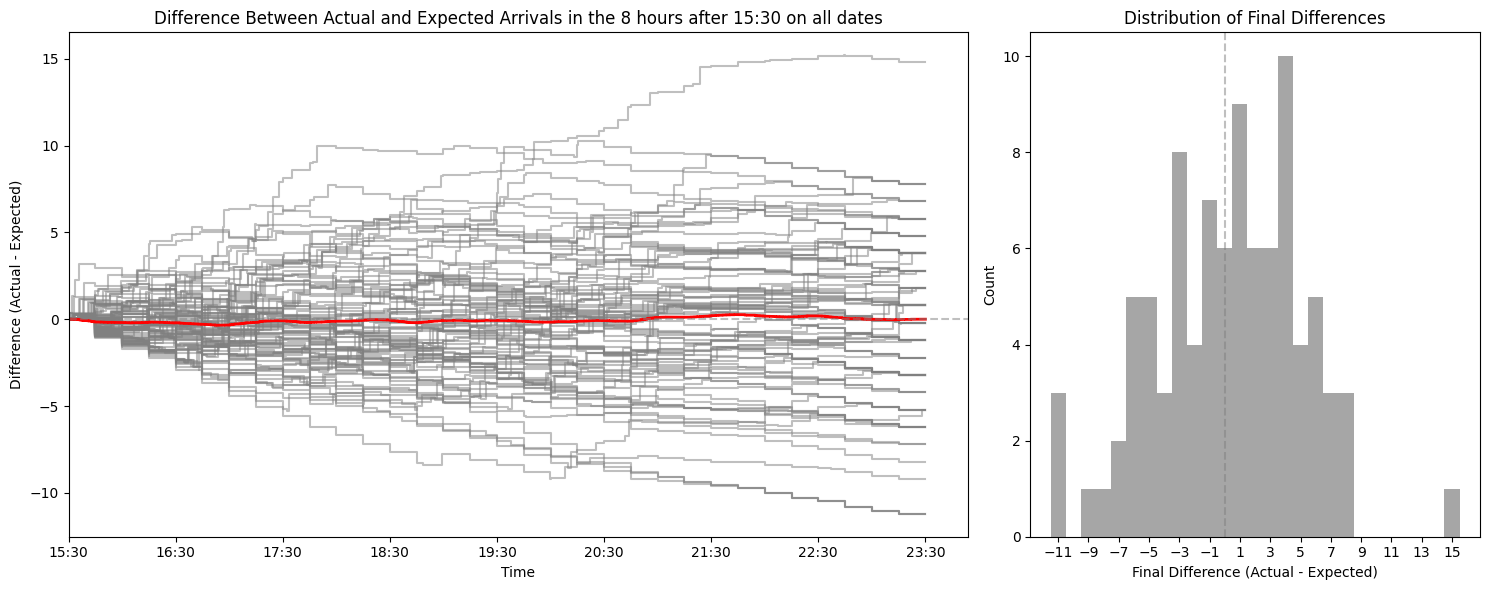

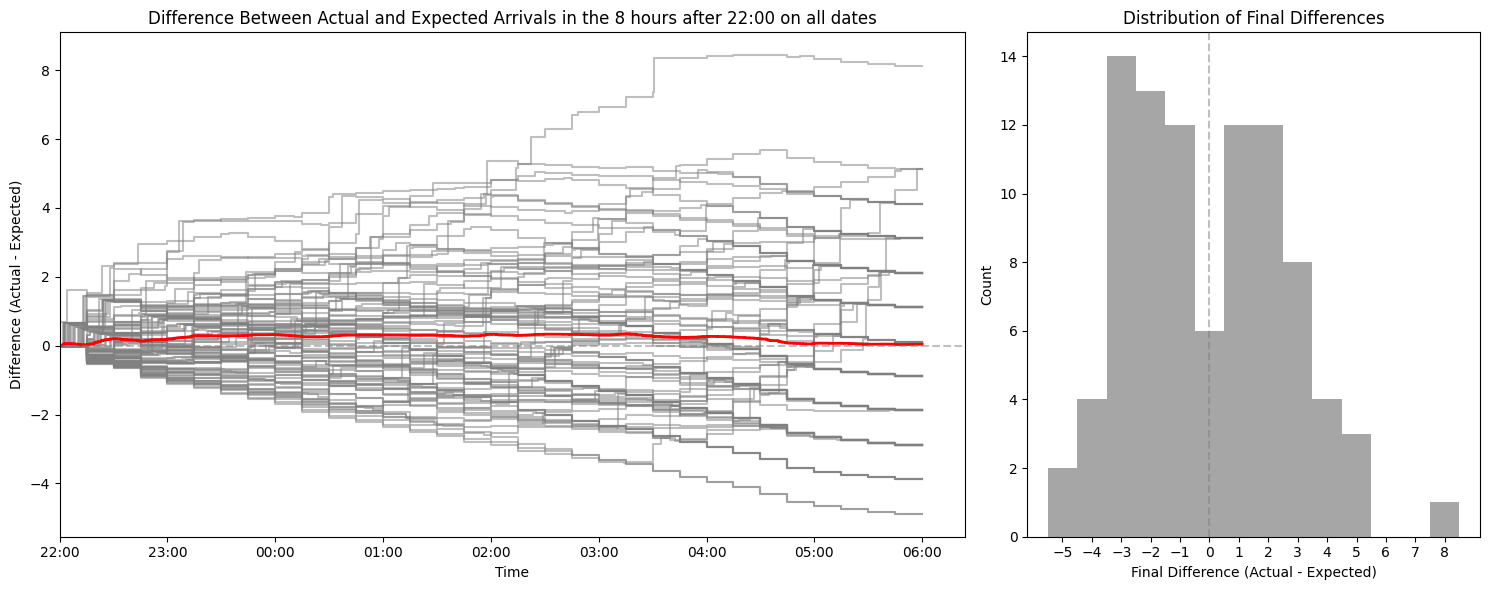

In [16]:
from patientflow.viz.observed_against_expected import plot_arrival_deltas
from datetime import timedelta


start_date = start_test_set
end_date = end_test_set
snapshot_dates = []

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

        # Sort prediction times by converting to minutes since midnight
prediction_times_sorted = sorted(
    ed_visits.prediction_time.unique(),
    key=lambda x: x[0] * 60 + x[1],  # Convert (hour, minute) to minutes since midnight
)

for prediction_time in prediction_times_sorted:
    plot_arrival_deltas(test_inpatient_arrivals_df, 
                         prediction_time, 
                         snapshot_dates, 
                        prediction_window=timedelta(minutes=params["prediction_window"]), 
                        yta_time_interval = timedelta(minutes=params["yta_time_interval"])
                         )

## Summary

In this notebook I have shown how to evaluate predicted bed counts for the patients in ED, by specialty, and for the patients yet-to-arrive. Both approaches required adjustments for the fact that the predicted distributions are aspirational. 

These models are based on a relatively small dataset (nine months of training data, a one month validation set and a 3 month test set).  In the real-time application at UCLH, we use more training data, and we also have the benefit of some additional features which improve model performance. 

Nonetheless, the models perform well on the relatively small datasets made available here. 